# Illumination profile

In this notebook, we validate several of the expressions in the paper related to the illumination profile due to a point source on the projected disk of a sphere.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
import sympy

np.seterr(invalid="ignore");

The illumination at a point on the surface is $I = \text{max}(0, \cos\theta_i)$, where $\theta_i$ is the angle between the surface normal and the incident light. We can compute the illumination profile on the surface of the sky-projected sphere given the illumination source Cartesian coordinate vector $\mathbf{s}$ as follows:

In [74]:
def compute_illumination_from_s(s, res=300):
    
    # Construct a uniform grid over the unit disk
    x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
    z = np.sqrt(1 - x ** 2 - y ** 2)
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)
    z = z.reshape(1, -1)
    
    # The surface normal at a point is easy in Cartesian coords:
    n = np.vstack([x, y, z])
    
    # Compute the cosine of the angle of incidence.
    # It's just the dot product between the source vector
    # and the surface normal:
    cos_theta_i = np.dot(s, n)
    
    # The illumination profile is proportional to max(0, cos(theta_i))
    I = np.maximum(0, cos_theta_i) 
    
    # Normalize to get the units correct (see below)
    rs = np.sqrt(s[0] ** 2 + s[1] ** 2 + s[2] ** 2)
    I /= (np.pi * rs ** 2)
    
    # Reshape to image form
    I = I.reshape(res, res)
    return x, y, I

As we mention in the paper, we can also compute it as a function of the parameters of the terminator ellipse, $b$ and $\theta$, as well as the distance to the source, $r_s$:

In [75]:
def compute_illumination_from_b_theta_rs(b, theta, rs, res=300):
    
    # Construct a uniform grid over the unit disk
    x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
    z = np.sqrt(1 - x ** 2 - y ** 2)
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)
    z = z.reshape(1, -1)
    
    # Complement of b
    bc = np.sqrt(1 - b ** 2)
    
    # Polynomial illumination
    I = -bc * np.sin(theta) * x + bc * np.cos(theta) * y - b * z
        
    # Remove the nightside, where the polynomial goes negative
    I = np.maximum(0, I)
    
    # Normalize to get the units correct (see below)
    I /= (np.pi * rs ** 2)
    
    # Reshape to image form
    I = I.reshape(res, res)
    return x, y, I

Let's visualize this for different values of $\mathbf{s}$ using a Jupyter widget. We'll show that our expression computed from $b$ and $\theta$ is equivalent:

In [76]:
@widgets.interact(xs=(-1.0, 1.0), ys=(-1.0, 1.0), zs=(-1.0, 1.0), res=widgets.fixed(300))
def visualize(xs=-0.3, ys=0.2, zs=0.3, res=300):
    
    # Set up the figure
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    for axis in ax:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_frame_on(False)
    ax[0].set_xlabel("from source vector")
    ax[1].set_xlabel(r"from $b$ and $\theta$")
               
    # Compute and plot the illumination given a source vector
    x, y, I = compute_illumination_from_s([xs, ys, zs], res=res)
    im = ax[0].imshow(I, origin="lower", extent=(-1, 1, -1, 1))
    
    # Get the semi-minor axis of the ellipse
    rs = np.sqrt(xs ** 2 + ys ** 2 + zs ** 2)
    b = -zs / rs
    
    # Get the orientation of the ellipse on the sky
    theta = -np.arctan2(xs, ys)
    
    # Compute and plot the illumination given b and theta
    x, y, I = compute_illumination_from_b_theta_rs(b, theta, rs, res=res)
    im = ax[1].imshow(I, origin="lower", extent=(-1, 1, -1, 1))
    
    # The equation for an ellipse parallel to the x axis
    x0 = np.linspace(-1, 1, 1000)
    y0 = b * np.sqrt(1 - x0 ** 2)
    
    # Rotate it by theta
    x = x0 * np.cos(theta) - y0 * np.sin(theta)
    y = x0 * np.sin(theta) + y0 * np.cos(theta)
    
    # Plot the ellipse
    ax[0].plot(x, y, "C1")
    ax[1].plot(x, y, "C1");

interactive(children=(FloatSlider(value=-0.3, description='xs', max=1.0, min=-1.0), FloatSlider(value=0.2, des…

The orange line is the day/night terminator, computed from the expressions in the text.

We also argue in the text that we must normalize the intensity by $\frac{1}{\pi r_s^2}$ to get the units correct, where $r_s$ is the distance to the source (in units where the radius of the illuminated body, i.e., the planet, is 1). To see why, let's look at our body at full phase (corresponding to $b = -1$ and any value of $\theta$), illuminated by a point source unit radius away. (The source is therefore sitting right above the surface of the body, which is unphysical for so many reasons, but never mind that for now).

In [ ]:
b = -1
theta = 0
rs = 1

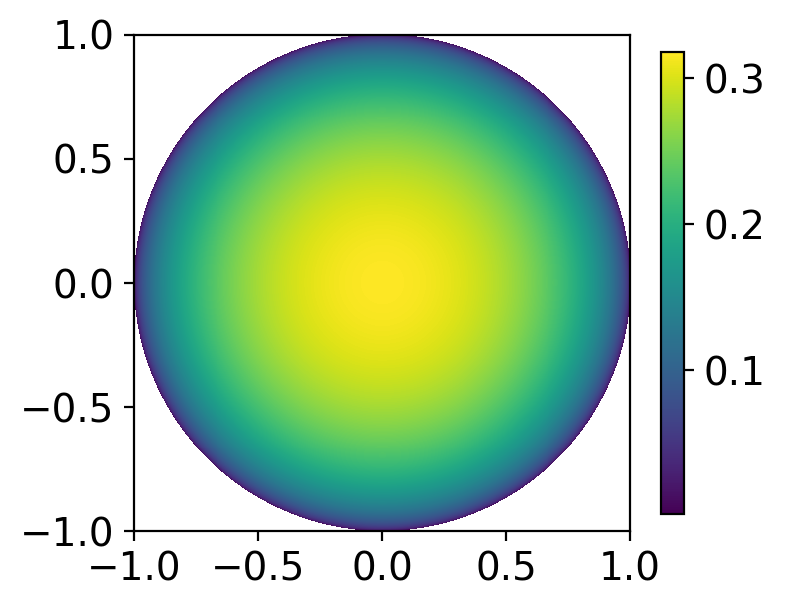

In [103]:
fig, ax = plt.subplots(1, figsize=(4, 4))
x, y, I = compute_illumination_from_b_theta_rs(b, theta, rs, res=1000)
im = ax.imshow(I, origin="lower", extent=(-1, 1, -1, 1))
plt.colorbar(im, shrink=0.75);

Let's integrate this intensity profile numerically to compute the *flux* measured by the observer. We will do this by summing the values of the intensity over the disk times the albedo (which we asssume to be unity) and times the tiny area of each pixel. If there are $N$ pixels, each one has area 
$dA = \frac{2}{\sqrt{N}}\times\frac{2}{\sqrt{N}} = \frac{4}{N}$:

In [104]:
dA = 4.0 / len(I.flat)
dA

4e-06

The total flux is thus (at two significant figures, the precision of the numerical integration)

In [106]:
f = np.nansum(I) * dA
print("{:.2f}".format(f))

0.67


At higher precision, it's clear that [the answer](https://www.wolframalpha.com/input/?i=integrate+sqrt%281+-+x%5E2+-+y%5E2%29%2Fpi+from+y+%3D+-sqrt%281+-+x%5E2%29+to+y+%3D+sqrt%281+-+x%5E2%29+and+x+%3D+-1+to+x+%3D+1) is exactly $\frac{2}{3}$. This is equal to the geometric albedo of a Lambert sphere, which means that a Lambert sphere is $2/3$ as bright as a disk of the same (projected) size, illuminated with the same intensity.

## The illumination operator

Since we can write the (dayside portion of the) illumination profile as a polynomial, we can construct a linear operator $\mathbf{I}$ that weights an albedo map expressed in the polynomial basis on the sphere. From the original `starry` paper, we may compute the terms in the polynomial basis from

In [115]:
def get_ijk(n):
    """Get the exponents of x, y, z i the nth term of the polynomial basis."""
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if mu % 2 == 0:
        i = mu // 2
        j = nu // 2
        k = 0
    else:
        i = (mu - 1) // 2
        j = (nu - 1) // 2
        k = 1
    return i, j, k


def poly_basis(x, y, z, deg):
    """Return the polynomial basis evaluated at `x`, `y`, `z`."""
    N = (deg + 1) ** 2
    try:
        B = np.zeros((len(x * y * z), N))
    except TypeError:
        B = np.zeros((1, N), dtype="object")
    for n in range(N):
        i, j, k = get_ijk(n)
        B[:, n] = x ** i * y ** j * z ** k
    return B

For reference, here's the basis up to total degree $l = 3$:

In [135]:
x, y, z = sympy.symbols("x y z")
list(poly_basis(x, y, z, 3)[0])

[1,
 x,
 z,
 y,
 x**2,
 x*z,
 x*y,
 y*z,
 y**2,
 x**3,
 x**2*z,
 x**2*y,
 x*y*z,
 x*y**2,
 y**2*z,
 y**3]

The illumination polynomial may be written in this basis as

In [140]:
def get_i(b, theta, rs):
    bc = np.sqrt(1 - b ** 2)
    return np.array([0, -bc * np.sin(theta), -b, bc * np.cos(theta)]) / (np.pi * rs ** 2)

Let's construct the illumination operator for a degree $l = 1$ map, as in the example presented in the paper. This operator will transform a degree $l = 1$ map in the polynomial basis to a degree $l = 2$ *illuminated* map, still in the polynomial basis.

In [141]:
def get_I(b, theta, rs):
    i = get_i(b, theta, rs)
    I = np.zeros((9, 4))
    I[:, 0] = [i[0], i[1], i[2], i[3], 0, 0, 0, 0, 0]
    I[:, 1] = [0, i[0], 0, 0, i[1], i[2], i[3], 0, 0]
    I[:, 2] = [i[2], 0, i[0], 0, -i[2], i[1], 0, i[3], -i[2]]
    I[:, 3] = [0, 0, 0, i[0], 0, 0, i[1], i[2], i[3]]
    return I

Here's what that looks like for a particular value of the inputs:

In [142]:
b = 0.5
theta = 30 * np.pi / 180
rs = 1
I = get_I(b, theta, rs)
print(I)

[[ 0.          0.         -0.15915494  0.        ]
 [-0.13783222  0.          0.          0.        ]
 [-0.15915494  0.          0.          0.        ]
 [ 0.23873241  0.          0.          0.        ]
 [ 0.         -0.13783222  0.15915494  0.        ]
 [ 0.         -0.15915494 -0.13783222  0.        ]
 [ 0.          0.23873241  0.         -0.13783222]
 [ 0.          0.          0.23873241 -0.15915494]
 [ 0.          0.          0.15915494  0.23873241]]


# Work in progress!